In [1]:
import numpy as np
import pandas as pd
import csv
import matplotlib.pyplot as plt

import tensorflow as tf

from keras.models import Sequential
from keras.layers import Input, Dense, MaxPooling2D, Conv2D, Flatten
from keras.optimizers import Adam
from keras import regularizers
from keras import optimizers
from keras import initializers
from keras.preprocessing import image

import keras.backend as K

from sklearn.preprocessing import OneHotEncoder
from sklearn.utils import shuffle

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

Using TensorFlow backend.


In [2]:
# Read images
images = np.zeros((480,260,400))

for i in range(480):
    filename = 'dataOpenedEye/openedEye'+str(i)+'.jpg'
    img=mpimg.imread(filename)
    images[i] = img

images = np.reshape(images, (images.shape[0], images.shape[1], images.shape[2], 1))

# Rescale images
images = images/255.

images.shape

(480, 260, 400, 1)

In [ ]:
%matplotlib notebook
display = np.reshape(images[18], (260,400))
plt.imshow(display, cmap='gray')
plt.show()

In [3]:
# Read target values
target = pd.read_csv('dataOpenedEye/dataPupilCenter.csv')

target.head()

,id,xcentral,ycentral
0,0,220,90
1,1,235,102
2,2,221,138
3,3,307,84
4,4,295,80


In [4]:
# Remove missing values
images = images[target.xcentral != '?']
target = target[target.xcentral != '?']
target = target.astype('float32')
target.shape

(446, 3)

In [5]:
# Put target data in shape
targetX = target['xcentral'].values.reshape((target['xcentral'].shape[0], 1))
targetY = target['ycentral'].values.reshape((target['ycentral'].shape[0], 1))

# Rescale targets between 0 and 1 
targetX = targetX/400.
targetY = targetY/260.

targetTrain = np.concatenate((targetX, targetY), axis=1)
targetTrain.shape

(446, 2)

In [6]:
# Shuffle data
xtrain, ytrain = shuffle(images, targetTrain, random_state=0)


In [7]:
def model(Xshape):
    
    mod = Sequential()
    mod.add(Conv2D(4, (7, 7), activation='relu', kernel_initializer='glorot_normal', input_shape=Xshape))
    mod.add(MaxPooling2D(pool_size=(4, 4)))
    
    mod.add(Conv2D(4, (7, 7), activation='relu', kernel_initializer='glorot_normal'))
    mod.add(MaxPooling2D(pool_size=(4, 4)))

    mod.add(Flatten())
#    mod.add(Dense(256, activation='relu', kernel_initializer='glorot_normal', kernel_regularizer=regularizers.l2(0.01)))
    mod.add(Dense(128, activation='relu', kernel_initializer='glorot_normal', kernel_regularizer=regularizers.l2(0.0)))
#    mod.add(Dense(256, activation='relu', kernel_initializer='glorot_normal', kernel_regularizer=regularizers.l2(0.0)))
    mod.add(Dense(2, activation='sigmoid', kernel_initializer='glorot_normal'))
    
    return mod

In [8]:
mymodel = model(xtrain.shape[1:])
opt = optimizers.Adam(lr=0.0001)
mymodel.compile(loss='mean_squared_error', optimizer=opt, metrics=['accuracy'])

In [10]:
mymodel.fit(xtrain, ytrain, epochs = 40, batch_size=64)

Epoch 1/50
446/446 [==============================] - 17s 39ms/step - loss: 0.0066 - acc: 0.9395
Epoch 2/50
446/446 [==============================] - 17s 39ms/step - loss: 0.0062 - acc: 0.9462
Epoch 3/50
446/446 [==============================] - 17s 39ms/step - loss: 0.0058 - acc: 0.9529
Epoch 4/50
446/446 [==============================] - 17s 39ms/step - loss: 0.0056 - acc: 0.9574
Epoch 5/50
446/446 [==============================] - 17s 39ms/step - loss: 0.0053 - acc: 0.9507
Epoch 6/50
446/446 [==============================] - 17s 39ms/step - loss: 0.0050 - acc: 0.9596
Epoch 7/50
446/446 [==============================] - 18s 40ms/step - loss: 0.0048 - acc: 0.9574
Epoch 8/50
446/446 [==============================] - 17s 39ms/step - loss: 0.0045 - acc: 0.9574
Epoch 9/50
446/446 [==============================] - 17s 39ms/step - loss: 0.0043 - acc: 0.9596
Epoch 10/50
446/446 [==============================] - 17s 39ms/step - loss: 0.0043 - acc: 0.9484
Epoch 11/50
446/446 [========

KeyboardInterrupt: 

In [25]:
# Make the prediction
ypredict = mymodel.predict(images)

In [15]:
ypredict[0,0]

0.81796724

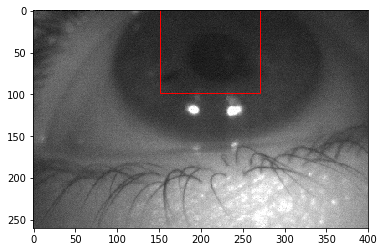

In [45]:
import matplotlib.patches as patches
#%matplotlib notebook
index=138

display = np.reshape(images[index], (260,400))
box = ypredict[index]

# Create figure and axes
fig,ax = plt.subplots(1)

# Display the image
ax.imshow(display, cmap='gray')

# Create a Rectangle patch
rect = patches.Rectangle((box[0]*400-60,box[1]*260-60),120,120,linewidth=1,edgecolor='r',facecolor='none')

# Add the patch to the Axes
ax.add_patch(rect)

plt.show()